# Week 7 Project

Jiwei Xia

In [1]:
# upload documents, run this only when using Google Colab
from google.colab import files
uploaded = files.upload()

Saving DailyReturn.csv to DailyReturn.csv
Saving F-F_Momentum_Factor_daily.csv to F-F_Momentum_Factor_daily.csv
Saving F-F_Research_Data_Factors_daily.csv to F-F_Research_Data_Factors_daily.csv
Saving problem2.csv to problem2.csv
Saving risklib.py to risklib.py


In [113]:
# import packages
from scipy.stats import norm, t
import scipy
import numpy as np
import pandas as pd
import risklib
from datetime import datetime
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

## Problem 1

* Current Stock Price \$165
* Strike Price \$165
* Current Date 03/13/2022
* Options Expiration Date 04/15/2022
* Risk Free Rate of 0.25%
* Continuously Compounding Coupon of 0.53%

Implement the closed form greeks for GBSM. Implement a finite difference derivative calculation.
Compare the values between the two methods for both a call and a put.

Implement the binomial tree valuation for American options with and without discrete dividends. Assume
the stock above:
* Pays dividend on 4/11/2022 of \$0.88

Calculate the value of the call and the put. Calculate the Greeks of each.

What is the sensitivity of the put and call to a change in the dividend amount?

### 1.1 Closed form greeks for GBSM

In [114]:
current_date = datetime(2022, 3, 13)
expire_date = datetime(2022, 4, 15)
T = (expire_date - current_date).days / 365

S = 165
X = 165
sigma = 0.2

r = 0.0025
coupon = 0.0053
b = r - coupon

In [115]:
def calculate_d1(S, X, T, sigma, b):
  return (np.log(S / X) + (b + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))

def calculate_d2(d1, T, sigma):
  return d1 - sigma * np.sqrt(T)

In [116]:
def gbsm_delta(option_type, S, X, T, sigma, r, b):
  is_call = 1 if option_type == "Call" else -1
  d1 = calculate_d1(S, X, T, sigma, b)
  delta = norm.cdf(d1 * is_call, 0, 1) * is_call
  return delta

def gbsm_gamma(option_type, S, X, T, sigma, r, b):
  d1 = calculate_d1(S, X, T, sigma, b)
  d2 = calculate_d2(d1, T, sigma)
  gamma = norm.pdf(d1, 0, 1) / (S * sigma * np.sqrt(T))
  return gamma

def gbsm_vega(option_type, S, X, T, sigma, r, b):
  d1 = calculate_d1(S, X, T, sigma, b)
  d2 = calculate_d2(d1, T, sigma)
  vega = S * norm.pdf(d1, 0, 1) * np.sqrt(T)
  return vega

def gbsm_theta(option_type, S, X, T, sigma, r, b):
  is_call = 1 if option_type == "Call" else -1
  d1 = calculate_d1(S, X, T, sigma, b)
  d2 = calculate_d2(d1, T, sigma)
  theta = -S * np.exp((b - r) * T) * norm.pdf(d1, 0, 1) * sigma / (2 * np.sqrt(T)) \
          -(b - r) * S * np.exp((b - r) * T) * norm.cdf(d1 * is_call, 0, 1) * is_call \
          -r * X * np.exp(-r * T) * norm.cdf(d2 * is_call, 0, 1) * is_call
  return theta

def gbsm_rho(option_type, S, X, T, sigma, r, b):
  is_call = 1 if option_type == "Call" else -1
  d1 = calculate_d1(S, X, T, sigma, b)
  d2 = calculate_d2(d1, T, sigma)
  rho = X * T * np.exp(-r * T) * norm.cdf(d2 * is_call, 0, 1) * is_call
  return rho

def gbsm_carry_rho(option_type, S, X, T, sigma, r, b):
  is_call = 1 if option_type == "Call" else -1
  d1 = calculate_d1(S, X, T, sigma, b)
  d2 = calculate_d2(d1, T, sigma)
  carry_rho = S * T * np.exp((b - r) * T) * norm.cdf(d1 * is_call, 0, 1) * is_call
  return carry_rho

### 1.2 Finite difference derivative calculation and comparison.

In [117]:
import inspect

# calculate first order derivative
def first_order_der(func, x, delta):
  return (func(x + delta) - func(x - delta)) / (2 * delta)

# calculate second order derivative
def second_order_der(func, x, delta):
  return (func(x + delta) + func(x - delta) - 2 * func(x)) / delta ** 2

def cal_partial_derivative(func, order, arg_name, delta=1e-3):
  # initialize for argument names and order
  arg_names = list(inspect.signature(func).parameters.keys())
  derivative_fs = {1: first_order_der, 2: second_order_der}

  def partial_derivative(*args, **kwargs):
    # parse argument names and order
    args_dict = dict(list(zip(arg_names, args)) + list(kwargs.items()))
    arg_val = args_dict.pop(arg_name)

    def partial_f(x):
      p_kwargs = {arg_name:x, **args_dict}
      return func(**p_kwargs)
    return derivative_fs[order](partial_f, arg_val, delta)
  return partial_derivative

In [118]:
def gbsm(option_type, S, X, T, sigma, r, b):
  d1 = (np.log(S / X) + (b + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)
  is_call = 1 if option_type == "Call" else -1

  res = is_call * (S * np.e ** ((b - r) * T) * \
                   scipy.stats.norm(0, 1).cdf(is_call * d1) \
                   - X * np.e ** (-r * T) * \
                   scipy.stats.norm(0, 1).cdf(is_call * d2))
    
  return res

In [119]:
# delta
delta_call = gbsm_delta("Call", S, X, T, sigma, r, b)
delta_put = gbsm_delta("Put", S, X, T, sigma, r, b)
gbsm_delta_num = cal_partial_derivative(gbsm, 1, 'S')
delta_call_num = gbsm_delta_num("Call", S, X, T, sigma, r, b)
delta_put_num = gbsm_delta_num("Put", S, X, T, sigma, r, b)
print(delta_call, delta_put)
print(delta_call_num, delta_put_num)

0.5103150338214995 -0.48968496617850055
0.5100705605514122 -0.4894503761363467


In [120]:
# gamma
gamma_call = gbsm_gamma("Call", S, X, T, sigma, r, b)
gamma_put = gbsm_gamma("Put", S, X, T, sigma, r, b)
gbsm_gamma_num = cal_partial_derivative(gbsm, 2, 'S')
gamma_call_num = gbsm_gamma_num("Call", S, X, T, sigma, r, b)
gamma_put_num = gbsm_gamma_num("Put", S, X, T, sigma, r, b)
print(gamma_call, gamma_put)
print(gamma_call_num, gamma_put_num)

0.040192071131753174 0.040192071131753174
0.040172778881242266 0.04017286414637056


In [121]:
# vega
vega_call = gbsm_vega("Call", S, X, T, sigma, r, b)
vega_put = gbsm_vega("Put", S, X, T, sigma, r, b)
gbsm_vega_num = cal_partial_derivative(gbsm, 1, 'sigma')
vega_call_num = gbsm_vega_num("Call", S, X, T, sigma, r, b)
vega_put_num = gbsm_vega_num("Put", S, X, T, sigma, r, b)
print(vega_call, vega_put)
print(vega_call_num, vega_put_num)

19.786061099476896 19.786061099476896
19.776582245050633 19.77658224505774


In [122]:
# theta
theta_call = gbsm_theta("Call", S, X, T, sigma, r, b)
theta_put = gbsm_theta("Put", S, X, T, sigma, r, b)
gbsm_theta_num = cal_partial_derivative(gbsm, 1, 'T')
theta_call_num = -gbsm_theta_num("Call", S, X, T, sigma, r, b)
theta_put_num = -gbsm_theta_num("Put", S, X, T, sigma, r, b)
print(theta_call, theta_put)
print(theta_call_num, theta_put_num)

-21.62860677878208 -22.090281063696036
-21.6289417361466 -22.090616021081644


In [123]:
# rho
rho_call = gbsm_rho("Call", S, X, T, sigma, r, b)
rho_put = gbsm_rho("Put", S, X, T, sigma, r, b)
gbsm_rho_num = cal_partial_derivative(gbsm, 1, 'r')
rho_call_num = gbsm_rho_num("Call", S, X, T, sigma, r, b)
rho_put_num = gbsm_rho_num("Put", S, X, T, sigma, r, b)
print(rho_call, rho_put)
print(rho_call_num, rho_put_num)

7.253304276901479 -7.661132489946645
-0.3558305251516458 -0.35960564720483035


In [124]:
# carry rho
carry_rho_call = gbsm_carry_rho("Call", S, X, T, sigma, r, b)
carry_rho_put = gbsm_carry_rho("Put", S, X, T, sigma, r, b)
gbsm_carry_rho_num = cal_partial_derivative(gbsm, 1, 'b')
carry_rho_call_num = gbsm_carry_rho_num("Call", S, X, T, sigma, r, b)
carry_rho_put_num = gbsm_carry_rho_num("Put", S, X, T, sigma, r, b)
print(carry_rho_call, carry_rho_put)
print(carry_rho_call_num, carry_rho_put_num)

7.609134801578659 -7.301526843244096
7.609135023443514 -7.301526641683154


### 1.3 Binomial tree valuation for American options with and without discrete dividends

In [125]:
def n_nodes(N):
    return (N + 2) * (N + 1) // 2

def node_index(i, j):
    return n_nodes(j - 1) + i

def binomial_tree_no_div(option_type, S0, X, T, sigma, r, N):
  is_call = 1 if option_type == "Call" else -1
  dt = T / N
  disc = np.exp(-r * dt)
  u = np.exp(sigma * np.sqrt(dt))
  d = 1 / u
  p = (np.exp(r * dt) - d) / (u - d)
    
  C = np.empty(n_nodes(N), dtype=float)
            
  for i in np.arange(N, -1, -1):
    for j in range(i, -1, -1):
      S = S0 * u ** j * d ** (i - j)
      index = node_index(j, i)
      C[index] = max(0, (S - X) * is_call)
      if i < N:
        val = disc * (p * C[node_index(j + 1, i + 1)] + (1 - p) * C[node_index(j, i + 1)])
        C[index] = max(C[index], val)
                
  return C[0]

def binomial_tree(option_type, S0, X, T, div_time, div, sigma, r, N):
  if div_date is None or div is None:
    return binomial_tree_no_div(option_type, S0, X, T, sigma, r, N)
  
  is_call = 1 if option_type == "Call" else -1
  dt = T / N
  disc = np.exp(-r * dt)
    
  #calculate u, d, and p
  u = np.exp(sigma * np.sqrt(dt))
  d = 1 / u
  p = (np.exp(r * dt) - d) / (u - d)

  new_T = T - div_time * dt
  new_N = N - div_time

  C = np.empty(n_nodes(div_time), dtype=float)
  for i in range(div_time, -1, -1):
    for j in range(i, -1, -1):
      S = S0 * u ** j * d ** (i - j)
      val_exe = max(0, (S - X) * is_call)
      if i < div_time:
        val = disc * (p * C[node_index(j + 1, i + 1)] + (1 - p) * C[node_index(j, i + 1)])
      else:
        val = binomial_tree(option_type, S - div, X, new_T, None, None, sigma, r, new_N)
      C[node_index(j, i)] = max(val_exe, val)
    
  return C[0]

### 1.4 Calculate the value of the call and the put. Calculate the Greeks of each.

In [126]:
# Assume N is 200
N = 200
value_no_div_call = binomial_tree_no_div("Call", S, X, T, sigma, r, N)
value_no_div_put = binomial_tree_no_div("Put", S, X, T, sigma, r, N)
print("Binomial tree value without dividend for call: " + str(value_no_div_call))
print("Binomial tree value without dividend for put: " + str(value_no_div_put))

Binomial tree value without dividend for call: 3.9712211422455805
Binomial tree value without dividend for put: 3.9356607180892844


In [127]:
div_date = datetime(2022, 4, 11)
div = 0.88
div_time = int((div_date - current_date).days / (expire_date - current_date).days * N)

value_call = binomial_tree("Call", S, X, T, div_time, div, sigma, r, N)
value_put = binomial_tree("Put", S, X, T, div_time, div, sigma, r, N)
print("Binomial tree value with dividend for call: " + str(value_call))
print("Binomial tree value with dividend for put: " + str(value_put))

Binomial tree value with dividend for call: 3.844705214527796
Binomial tree value with dividend for put: 4.406498686439346


In [128]:
# delta
cal_amr_delta_num = cal_partial_derivative(binomial_tree, 1, 'S0')
delta_call_amr = cal_amr_delta_num("Call", S, X, T, div_time, div, sigma, r, N)
delta_put_amr = cal_amr_delta_num("Put", S, X, T, div_time, div, sigma, r, N)
print(delta_call_amr, delta_put_amr)

0.5069898474061585 -0.5147689593596461


In [129]:
# gamma
cal_amr_gamma_num = cal_partial_derivative(binomial_tree, 2, 'S0', delta=1)
gamma_call_amr = cal_amr_gamma_num("Call", S, X, T, div_time, div, sigma, r, N)
gamma_put_amr = cal_amr_gamma_num("Put", S, X, T, div_time, div, sigma, r, N)
print(gamma_call_amr, gamma_put_amr)

0.042556305359782165 0.03347707060581584


In [130]:
# vega
cal_amr_vega_num = cal_partial_derivative(binomial_tree, 1, 'sigma')
vega_call_amr = cal_amr_vega_num("Call", S, X, T, div_time, div, sigma, r, N)
vega_put_amr = cal_amr_vega_num("Put", S, X, T, div_time, div, sigma, r, N)
print(vega_call_amr, vega_put_amr)

19.62875609090542 19.802282397992865


In [131]:
# theta
cal_amr_theta_num = cal_partial_derivative(binomial_tree, 1, 'T')
theta_call_amr = -cal_amr_theta_num("Call", S, X, T, div_time, div, sigma, r, N)
theta_put_amr = -cal_amr_theta_num("Put", S, X, T, div_time, div, sigma, r, N)
print(theta_call_amr, theta_put_amr)

-21.892622546609395 -21.691500679029474


In [132]:
# rho
cal_amr_rho_num = cal_partial_derivative(binomial_tree, 1, 'r')
rho_call_amr = cal_amr_rho_num("Call", S, X, T, div_time, div, sigma, r, N)
rho_put_amr = cal_amr_rho_num("Put", S, X, T, div_time, div, sigma, r, N)
print(rho_call_amr, rho_put_amr)

6.570936753961032 -7.640829804087534


### 1.5 What is the sensitivity of the put and call to a change in the dividend amount?

In [133]:
# sensitivity to change in dividend amount
# change the dividend amount on the first ex-dividend date by 1e-3
delta = 1e-3
call_value1 = binomial_tree("Call", S, X, T, div_time, div + delta, sigma, r, N)    
call_value2 = binomial_tree("Call", S, X, T, div_time, div - delta, sigma, r, N)    
call_sens_to_div_amount = (call_value1 - call_value2) / (2*delta)

put_value1 = binomial_tree("Put", S, X, T, div_time, div + delta, sigma, r, N)    
put_value2 = binomial_tree("Put", S, X, T, div_time, div - delta, sigma, r, N)    
put_sens_to_div_amount = (put_value1 - put_value2) / (2*delta)
print(f"Sensitivity to dividend amount: Call: {call_sens_to_div_amount:.3f}, Put: {put_sens_to_div_amount:.3f}")

Sensitivity to dividend amount: Call: -0.114, Put: 0.536


## Problem 2

Using the options portfolios from Problem3 last week (named problem2.csv in this week’s repo) and assuming :
* American Options
* Current Date 02/25/2022
* Current AAPL price is 164.85
* Risk Free Rate of 0.25%
* Dividend Payment of \$1.00 on 3/15/2022

Using DailyReturn.csv. Fit a Normal distribution to AAPL returns – assume 0 mean return. Simulate AAPL returns 10 days ahead and apply those returns to the current AAPL price (above). Calculate Mean, VaR and ES.

Calculate VaR and ES using Delta-Normal.

Present all VaR and ES values a $ loss, not percentages.

Compare these results to last week’s results.

### 2.1 Simulate through price changes

In [134]:
def implied_vol_american(option_type, S0, X, T, div_time, div, r, N, market_price, x0=0.5):
  def equation(sigma):
    return binomial_tree(option_type, S0, X, T, div_time, div, sigma, r, N) - market_price
  # Back solve the binomial tree valuation to get the implied volatility
  return scipy.optimize.fsolve(equation, x0=x0, xtol=0.00001)[0]

def calculate_sim_values(portfolios, sim_prices, days_ahead=0):
  sim_values = pd.DataFrame(index=portfolios.index, 
                            columns=list(range(sim_prices.shape[0])))
  sim_prices = np.array(sim_prices)
  for i in portfolios.index:
    if portfolios["Type"][i] == "Stock":
      # For stock, the single value is its price
      single_values = sim_prices
    else:
      # For option, calculate values with gbsm method
      option_type = portfolios["OptionType"][i]
      X = portfolios["Strike"][i]
      T = ((portfolios["ExpirationDate"][i] - current_date).days - days_ahead) / 365
      sigma = portfolios["ImpliedVol"][i]
      div_time = int((div_date - current_date).days / (portfolios["ExpirationDate"][i] - current_date).days * N)
      div = 1
      option_values = []
      for S in sim_prices:
        option_values.append(binomial_tree(option_type, S, X, T, div_time, div, sigma, r, N))
      single_values = np.array(option_values)
    
    # Calculate the total values based on holding
    sim_values.loc[i, :] = portfolios["Holding"][i] * single_values
  
  # Combine the values for same portfolios
  sim_values['Portfolio'] = portfolios['Portfolio']
  return sim_values.groupby('Portfolio').sum()

In [135]:
portfolios = pd.read_csv('problem2.csv', parse_dates=['ExpirationDate'])
portfolios['CurrentValue'] = portfolios['CurrentPrice'] * portfolios['Holding']

S = 164.85
N = 25
current_date = datetime(2022, 2, 25)
div_date = datetime(2022, 3, 15)
r = 0.0025
div = 1

# Calculate the implied volatility for all portfolios
implied_vols = []
for i in range(len(portfolios.index)):
  if portfolios["Type"][i] == "Stock":
    implied_vols.append(None)
  else:
    option_type = portfolios["OptionType"][i]
    X = portfolios["Strike"][i]
    T = (portfolios["ExpirationDate"][i] - current_date).days / 365
    div_time = int((div_date - current_date).days / (portfolios["ExpirationDate"][i] - current_date).days * N)
    market_price = portfolios["CurrentPrice"][i]
    sigma = implied_vol_american(option_type, S, X, T, div_time, div, r, N, market_price)
    implied_vols.append(sigma)

# Store the implied volatility in portfolios
portfolios["ImpliedVol"] = implied_vols

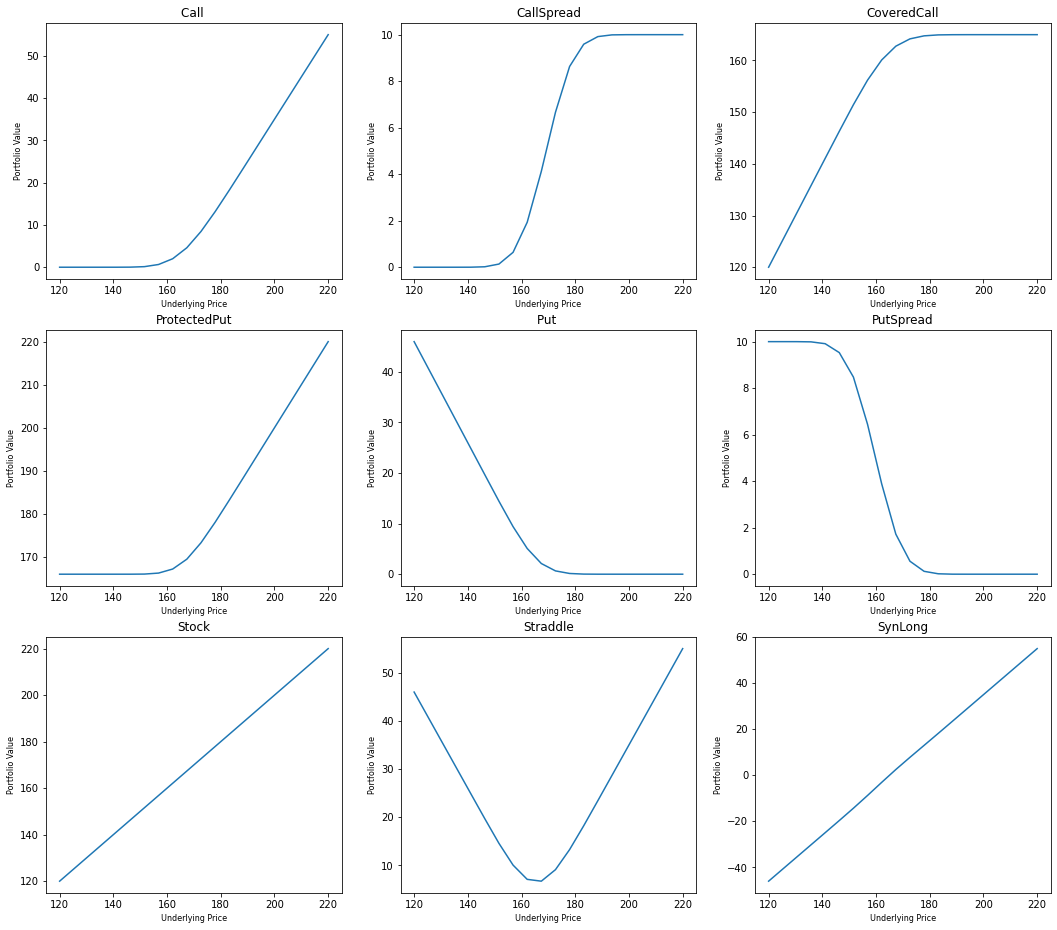

In [136]:
# Simulate the price in 120-220 range
sim_prices = np.linspace(120, 220, 20)

# Calculate the stock and option values
sim_values = calculate_sim_values(portfolios, sim_prices, 10)

# Plot the values for each portfolio
fig, axes = plt.subplots(3, 3, figsize=(18, 16))
idx = 0
for portfolio, dataframe in sim_values.groupby('Portfolio'):
  i, j = idx // 3, idx % 3
  ax = axes[i][j]
  ax.plot(sim_prices, dataframe.iloc[0, :].values)
  ax.set_title(portfolio)
  ax.set_xlabel('Underlying Price', fontsize=8)
  ax.set_ylabel('Portfolio Value', fontsize=8)
  idx += 1

### 2.2 Fit a Normal distribution and calculate Mean, VaR and ES.

In [137]:
S = 164.85
N = 25
current_date = datetime(2022, 2, 25)
div_date = datetime(2022, 3, 15)
r = 0.0025
div = 1

all_returns = pd.read_csv("DailyReturn.csv")

# Simulate the prices based on returns with normal distribution
std = all_returns['AAPL'].std()
np.random.seed(0)
sim_returns = scipy.stats.norm(0, std).rvs((10, 100))
sim_prices = 164.85 * (1 + sim_returns).prod(axis=0)

# Calculate the current values and sim values
portfolios["CurrentValue"] = portfolios["CurrentPrice"] * portfolios["Holding"]
curr_values = portfolios.groupby('Portfolio')['CurrentValue'].sum()
sim_values = calculate_sim_values(portfolios, sim_prices, 10)

# Calculate the value difference
sim_value_changes = (sim_values.T - curr_values).T

# Calculate the Mean, VaR and ES, and print the results
result = pd.DataFrame(index=sim_value_changes.index)
result['Mean'] = sim_value_changes.mean(axis=1)
result['VaR'] = sim_value_changes.apply(lambda x:risklib.calculate_var(x, 0), axis=1)
result['ES'] = sim_value_changes.apply(lambda x:risklib.calculate_es(x), axis=1)
result

,Mean,VaR,ES
Portfolio,,,
Call,-0.456855,4.396249,4.471327
CallSpread,-0.600917,3.676363,3.751333
CoveredCall,-0.727452,9.661461,13.625566
ProtectedPut,0.018829,3.239450,3.257070
Put,1.203136,4.216102,4.341854
PutSpread,0.938195,2.640985,2.749500
Stock,-1.184307,14.057710,18.096893
Straddle,0.746281,2.340510,2.359838
SynLong,-1.659991,15.214509,19.311149


### 2.3 Calculate VaR and ES using Delta-Normal.

In [138]:
S = 164.85
N = 25
current_date = datetime(2022, 2, 25)
div_date = datetime(2022, 3, 15)
r = 0.0025
div = 1

cal_amr_delta_num =  cal_partial_derivative(binomial_tree, 1, 'S0')

# Calculate the implied volatility for all portfolios
deltas = []
for i in range(len(portfolios.index)):
  if portfolios["Type"][i] == "Stock":
    deltas.append(1)
  else:
    option_type = portfolios["OptionType"][i]
    X = portfolios["Strike"][i]
    T = ((portfolios["ExpirationDate"][i] - current_date).days - 10) / 365
    div_time = int((div_date - current_date).days / (portfolios["ExpirationDate"][i] - current_date).days * N)
    delta = cal_amr_delta_num(option_type, S, X, T, div_time, div, sigma, r, N)
    deltas.append(delta)

# Store the deltas in portfolios
portfolios["deltas"] = deltas

alpha = 0.05
t = 10
result_dn = pd.DataFrame(index=sorted(portfolios['Portfolio'].unique()), columns=['Mean', 'VaR', 'ES'])
result_dn.index.name = 'Portfolio'
for pfl, df in portfolios.groupby('Portfolio'):
  gradient = S / df['CurrentValue'].sum() * (df['Holding'] * df['deltas']).sum()
  pfl_10d_std = abs(gradient) * std * np.sqrt(t)
  N = scipy.stats.norm(0, 1)
  present_value = df['CurrentValue'].sum() 
  result_dn.loc[pfl]['Mean'] = 0
  result_dn.loc[pfl]['VaR'] = -present_value * N.ppf(alpha) * pfl_10d_std
  result_dn.loc[pfl]['ES'] = present_value * pfl_10d_std * N.pdf(N.ppf(alpha)) / alpha

result_dn

,Mean,VaR,ES
Portfolio,,,
Call,0,7.84314,9.835613
CallSpread,0,6.943888,8.707916
CoveredCall,0,5.915268,7.417984
ProtectedPut,0,7.004823,8.78433
Put,0,6.753585,8.469267
PutSpread,0,5.23457,6.564362
Stock,0,13.758407,17.253598
Straddle,0,1.089555,1.366346
SynLong,0,14.596724,18.304881


### 2.4 Compare these results to last week’s results.

In [139]:
def calculate_sim_values_week6(portfolios, sim_prices, days_ahead=0):
  sim_values = pd.DataFrame(index=portfolios.index, 
                            columns=list(range(sim_prices.shape[0])))
  sim_prices = np.array(sim_prices)
  for i in portfolios.index:
    if portfolios["Type"][i] == "Stock":
      # For stock, the single value is its price
      single_values = sim_prices
    else:
      # For option, calculate values with gbsm method
      option_type = portfolios["OptionType"][i]
      S = sim_prices
      X = portfolios["Strike"][i]
      T = ((portfolios["ExpirationDate"][i] - current_date).days - days_ahead) / 365
      sigma = portfolios["ImpliedVol"][i]
      option_values = gbsm(option_type, S, X, T, sigma, r, b)
      single_values = option_values
    
    # Calculate the total values based on holding
    sim_values.loc[i, :] = portfolios["Holding"][i] * single_values
  
  # Combine the values for same portfolios
  sim_values['Portfolio'] = portfolios['Portfolio']
  return sim_values.groupby('Portfolio').sum()

S = 164.85
N = 25
current_date = datetime(2022, 2, 25)
div_date = datetime(2022, 3, 15)
r = 0.0025
div = 1

all_returns = pd.read_csv("DailyReturn.csv")

# Simulate the prices based on returns with normal distribution
std = all_returns['AAPL'].std()
np.random.seed(0)
sim_returns = scipy.stats.norm(0, std).rvs((10, 10000))
sim_prices = 164.85 * (1 + sim_returns).prod(axis=0)

# Calculate the current values and sim values
portfolios["CurrentValue"] = portfolios["CurrentPrice"] * portfolios["Holding"]
curr_values = portfolios.groupby('Portfolio')['CurrentValue'].sum()
sim_values = calculate_sim_values_week6(portfolios, sim_prices, 10)

# Calculate the value difference
sim_value_changes = (sim_values.T - curr_values).T

# Calculate the Mean, VaR and ES, and print the results
result_week6 = pd.DataFrame(index=sim_value_changes.index)
result_week6['Mean'] = sim_value_changes.mean(axis=1)
result_week6['VaR'] = sim_value_changes.apply(lambda x:risklib.calculate_var(x, 0), axis=1)
result_week6['ES'] = sim_value_changes.apply(lambda x:risklib.calculate_es(x), axis=1)
result_week6

,Mean,VaR,ES
Portfolio,,,
Call,0.189658,4.326889,4.418817
CallSpread,-0.192272,3.607492,3.699002
CoveredCall,-0.150953,8.982464,12.050965
ProtectedPut,-0.003394,4.188262,4.219615
Put,-0.042099,4.323100,4.368975
PutSpread,0.232737,2.734585,2.773792
Stock,0.038705,13.309352,16.469782
Straddle,0.147559,2.725637,2.735081
SynLong,0.231757,13.447979,16.668983


Text(0.5, 1.0, 'ES Comparison')

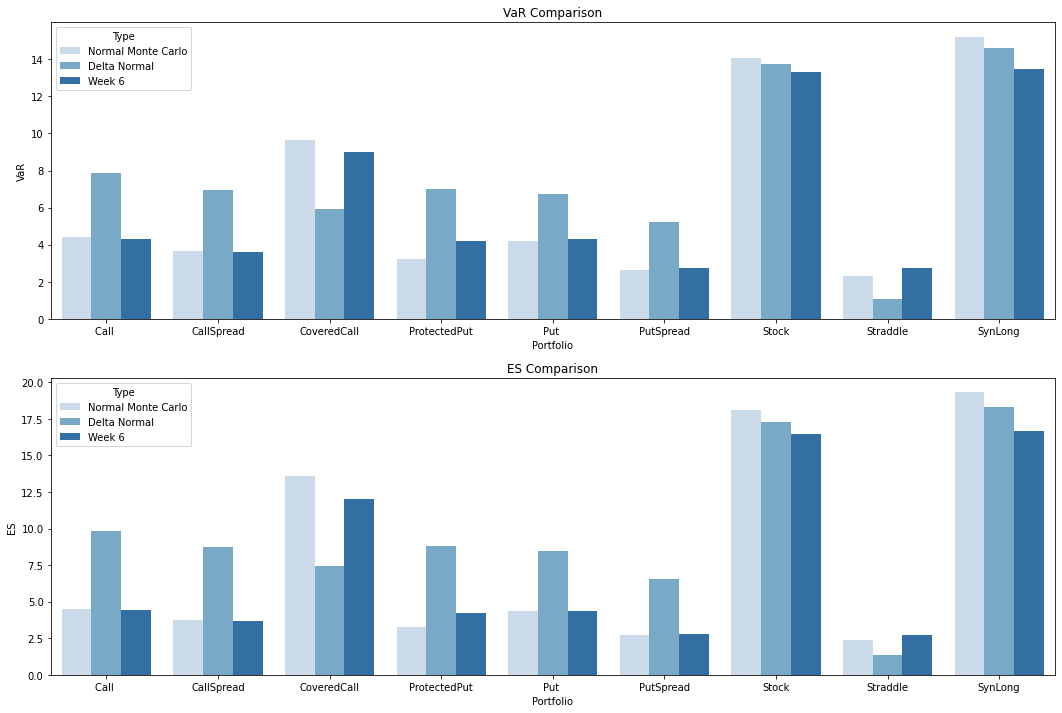

In [140]:
result_dfs = []
for category, result_df in zip(['Normal Monte Carlo', 'Delta Normal', 'Week 6'], [result, result_dn, result_week6]):
  new_result_df = result_df.reset_index()
  new_result_df['Type'] = category
  result_dfs.append(new_result_df)
result_dfs = pd.concat(result_dfs, axis=0)

fig, axes = plt.subplots(2, 1, figsize=(18, 12))
ax = sns.barplot(x='Portfolio', y='VaR', hue='Type', palette='Blues', data=result_dfs, ax=axes[0])
ax.set_title('VaR Comparison')

ax = sns.barplot(x='Portfolio', y='ES', hue='Type', palette='Blues', data=result_dfs, ax=axes[1])
ax.set_title('ES Comparison')

## Problem 3

Use the Fama French 3 factor return time series (F-F_Research_Data_Factors_daily.CSV) as well as the
Carhart Momentum time series (F-F_Momentum_Factor_daily.CSV) to fit a 4 factor model to the following
stocks.

AAPL FB UNH MA

MSFT NVDA HD PFE

AMZN BRK-B PG XOM

TSLA JPM V DIS

GOOGL JNJ BAC CSCO

Fama stores values as percentages, you will need to divide by 100 (or multiply the stock returns by 100) to get like units.

Based on the past 10 years of factor returns, find the expected annual return of each stock.

Construct an annual covariance matrix for the 10 stocks.

Assume the risk free rate is 0.0025. Find the super efficient portfolio.

In [141]:
# data preparation
ff = pd.read_csv('F-F_Research_Data_Factors_daily.csv', parse_dates=['Date']).set_index('Date')
mom = pd.read_csv('F-F_Momentum_Factor_daily.csv', parse_dates=['Date']).set_index('Date')
# transfer percentage to value
data = ff.join(mom, how='right') / 100

all_returns = pd.read_csv('DailyReturn.csv', parse_dates=['Date']).set_index('Date')
stocks = ['AAPL', 'FB', 'UNH', 'MA',  
          'MSFT' ,'NVDA', 'HD', 'PFE',  
          'AMZN' ,'BRK-B', 'PG', 'XOM',  
          'TSLA' ,'JPM' ,'V', 'DIS',  
          'GOOGL', 'JNJ', 'BAC', 'CSCO']
factors = ['Mkt-RF', 'SMB', 'HML', 'RF']
dataset = all_returns[stocks].join(data)

In [142]:
# calculate arithmetic E(r) in past 10 years
avg_factor_rets = data.loc['2012-1-14':'2022-1-14'].mean(axis=0)
avg_daily_rets = pd.Series()
for stock in stocks:
  # calculate betas
  model = sm.OLS(dataset[stock] - dataset['RF'], sm.add_constant(dataset[factors]))
  results = model.fit()
    
  # assume alpha = 0
  avg_daily_rets[stock] = (results.params[factors] * avg_factor_rets[factors]).sum() \
                          + avg_factor_rets['RF'] 

In [143]:
# geometric annual returns: mean and covariance
geo_means = np.log(1 + avg_daily_rets) * 255  
geo_covariance = np.log(1 + all_returns[stocks]).cov() * 255
print(geo_means)

AAPL     0.165589
FB       0.209209
UNH      0.130469
MA       0.213587
MSFT     0.197323
NVDA     0.408778
HD       0.133134
PFE     -0.116464
AMZN     0.166110
BRK-B    0.103523
PG       0.067988
XOM      0.179607
TSLA     0.280018
JPM      0.133943
V        0.173826
DIS      0.124469
GOOGL    0.199387
JNJ      0.051172
BAC      0.166199
CSCO     0.129557
dtype: float64


In [144]:
display(geo_covariance)

,AAPL,FB,UNH,MA,MSFT,NVDA,HD,PFE,AMZN,BRK-B,PG,XOM,TSLA,JPM,V,DIS,GOOGL,JNJ,BAC,CSCO
AAPL,0.065441,0.031073,0.020744,0.010865,0.039993,0.081306,0.020419,-0.021341,0.041714,0.000136,-0.002699,0.008210,0.081903,0.005251,0.010712,0.012826,0.031423,-0.003238,0.005305,0.011880
FB,0.031073,0.104613,0.008503,0.040435,0.037940,0.071235,0.007342,-0.034076,0.039219,0.009335,0.000548,0.016634,0.070407,0.003429,0.034626,0.029683,0.036417,0.005036,0.008607,0.016598
UNH,0.020744,0.008503,0.044678,0.025495,0.022884,0.037212,0.016155,-0.006501,0.018861,0.002269,0.011324,0.009566,0.024662,0.003660,0.018395,0.010282,0.021946,0.008787,0.003671,0.015559
MA,0.010865,0.040435,0.025495,0.129913,0.008331,0.032840,0.013766,-0.025942,0.018757,0.020274,0.012592,0.047964,0.042987,0.027444,0.098294,0.044054,0.010899,0.013416,0.040533,0.017995
MSFT,0.039993,0.037940,0.022884,0.008331,0.065237,0.089283,0.022864,-0.018821,0.033346,-0.001568,0.002797,0.004023,0.078434,-0.003993,0.003577,0.010030,0.051307,-0.001555,-0.000343,0.022863
NVDA,0.081306,0.071235,0.037212,0.032840,0.089283,0.354876,0.052871,-0.048652,0.100484,-0.003756,-0.009097,0.033804,0.188497,0.007134,0.041099,0.023697,0.083843,-0.013139,0.017036,0.013277
HD,0.020419,0.007342,0.016155,0.013766,0.022864,0.052871,0.058241,-0.022702,0.014528,0.000238,0.006162,0.005143,0.028978,0.014535,0.013316,0.011541,0.022639,0.002178,0.007904,0.003715
PFE,-0.021341,-0.034076,-0.006501,-0.025942,-0.018821,-0.048652,-0.022702,0.177019,-0.027410,-0.012057,0.005692,-0.036887,-0.055088,-0.022267,-0.015947,-0.023313,-0.021314,0.006779,-0.034283,-0.002152
AMZN,0.041714,0.039219,0.018861,0.018757,0.033346,0.100484,0.014528,-0.027410,0.066280,-0.001549,-0.003372,0.013645,0.041839,-0.001034,0.010257,0.017323,0.039699,-0.003340,0.002833,0.002798
BRK-B,0.000136,0.009335,0.002269,0.020274,-0.001568,-0.003756,0.000238,-0.012057,-0.001549,0.022978,0.009790,0.023074,-0.005053,0.022736,0.018162,0.010155,0.001378,0.009128,0.028815,0.007915


In [145]:
# arithmetic annual returns: mean and covariance
arith_means = np.exp(geo_means + np.diagonal(geo_covariance.values) / 2) - 1

nstocks = geo_covariance.shape[0]
arith_covariance = np.empty((nstocks, nstocks), dtype=float)
for i in range(nstocks):
  for j in range(i, nstocks):
    mu_i, mu_j = geo_means.iloc[i], geo_means.iloc[j]
    sigma2_i, sigma2_j = geo_covariance.iloc[i, i], geo_covariance.iloc[j, j]
    sigma_ij = geo_covariance.iloc[i, j]
    arith_covariance[i, j] = np.exp(mu_i + mu_j + (sigma2_i + sigma2_j) / 2) * (np.exp(sigma_ij) - 1)
    arith_covariance[j, i] = arith_covariance[i, j]
arith_covariance = pd.DataFrame(arith_covariance, columns=stocks, index=stocks)

print(arith_means)

AAPL     0.219339
FB       0.298898
UNH      0.165101
MA       0.321203
MSFT     0.258526
NVDA     0.797174
HD       0.176160
PFE     -0.027567
AMZN     0.220488
BRK-B    0.121886
PG       0.081514
XOM      0.243151
TSLA     0.712362
JPM      0.176181
V        0.249593
DIS      0.169874
GOOGL    0.259894
JNJ      0.064275
BAC      0.219665
CSCO     0.169785
dtype: float64


In [146]:
display(arith_covariance)

,AAPL,FB,UNH,MA,MSFT,NVDA,HD,PFE,AMZN,BRK-B,PG,XOM,TSLA,JPM,V,DIS,GOOGL,JNJ,BAC,CSCO
AAPL,0.100551,0.049986,0.029778,0.017599,0.062616,0.185616,0.029584,-0.025036,0.063391,0.000186,-0.003554,0.012496,0.178207,0.007551,0.016409,0.018414,0.049039,-0.004195,0.007910,0.017046
FB,0.049986,0.186059,0.012923,0.070814,0.063211,0.172352,0.011258,-0.042317,0.063409,0.013667,0.000770,0.027084,0.162242,0.005247,0.057185,0.045780,0.060693,0.006979,0.013695,0.025429
UNH,0.029778,0.012923,0.062024,0.039749,0.033941,0.079385,0.022318,-0.007341,0.027074,0.002969,0.014350,0.013921,0.049814,0.005024,0.027029,0.014087,0.032571,0.010943,0.005226,0.021372
MA,0.017599,0.070814,0.039749,0.242162,0.013911,0.079272,0.021540,-0.032902,0.030532,0.030357,0.018107,0.080698,0.099374,0.043238,0.170524,0.069614,0.018241,0.018992,0.066658,0.028063
MSFT,0.062616,0.063211,0.033941,0.013911,0.106772,0.211229,0.034234,-0.022818,0.052083,-0.002213,0.003812,0.006308,0.175834,-0.005899,0.005636,0.014841,0.083476,-0.002081,-0.000527,0.034047
NVDA,0.185616,0.172352,0.079385,0.079272,0.211229,1.375920,0.114764,-0.082990,0.231859,-0.007558,-0.017602,0.076814,0.638356,0.015133,0.094220,0.050418,0.198027,-0.024966,0.037662,0.028098
HD,0.029584,0.011258,0.022318,0.021540,0.034234,0.114764,0.082961,-0.025672,0.021007,0.000314,0.007862,0.007538,0.059215,0.020254,0.019702,0.015972,0.033929,0.002729,0.011383,0.005121
PFE,-0.025036,-0.042317,-0.007341,-0.032902,-0.022818,-0.082990,-0.025672,0.183124,-0.032090,-0.013075,0.006004,-0.043779,-0.089250,-0.025186,-0.019224,-0.026215,-0.025836,0.007039,-0.039972,-0.002445
AMZN,0.063391,0.063409,0.027074,0.030532,0.052083,0.231859,0.021007,-0.032090,0.102075,-0.002120,-0.004444,0.020845,0.089296,-0.001483,0.015723,0.024949,0.062273,-0.004332,0.004223,0.004000
BRK-B,0.000186,0.013667,0.002969,0.030357,-0.002213,-0.007558,0.000314,-0.013075,-0.002120,0.029255,0.011937,0.032555,-0.009682,0.030344,0.025694,0.013396,0.001949,0.010949,0.040002,0.010429


In [147]:
# calculate the most efficient portfolio which has the highest Sharpe ratio 
def neg_sharpe_ratio(weights, mean, cov, r):
  returns = mean @ weights.T
  std = np.sqrt(weights @ cov @ weights.T)
  return -(returns - r) / std

args = (arith_means, arith_covariance, 0.0025)
bounds = [(0.0, 1) for _ in stocks]
x0 = np.array(nstocks*[1 / nstocks])
constraints = {'type':'eq', 'fun': lambda x: np.sum(x) - 1}
results = scipy.optimize.minimize(neg_sharpe_ratio, x0=x0, args=args, bounds=bounds, constraints=constraints)
opt_sharpe, opt_weights = -results.fun, pd.Series(results.x, index=stocks)
opt_weights = pd.DataFrame(opt_weights, columns=['weights(%)'])
opt_weights['weights(%)'] = round(opt_weights*100, 2)

print("The most efficient portfolio consists of: ")
display(opt_weights)
print("The Portfolio's Sharpe Ratio is: " + str(opt_sharpe))

The most efficient portfolio consists of: 


,weights(%)
AAPL,0.00
FB,4.26
UNH,3.76
MA,1.26
MSFT,5.60
NVDA,0.44
HD,11.07
PFE,9.08
AMZN,9.59
BRK-B,24.80


The Portfolio's Sharpe Ratio is: 1.3042745402283054
